In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import datasets
from yellowbrick.cluster import KElbowVisualizer

import warnings

# Desativar todos os warnings
warnings.filterwarnings("ignore")

In [2]:

df = pd.read_excel(r'C:\Users\gabriel.valadao\Downloads\galo\GaloAnalytics\Data\prem_22_23.xlsx')
def dividir_posicoes(posicoes_string):
    return posicoes_string.split(', ')

# Aplicar a função a todas as células da coluna 'Posição' e criar uma nova coluna 'Posições Divididas'
df = df[df['Minutos jogados:'] > 720]
df['Posição'] = df['Posição'].apply(dividir_posicoes)
df = df[~df['Posição'].apply(lambda x: 'GK' in x)]
df.reset_index(drop=True, inplace=True)
df

,Jogador,Equipa,Posição,Idade,Valor de mercado,Contrato termina,Partidas jogadas,Minutos jogados:,Golos,Golos esperados,...,Receção de passes em profundidade/90,Cruzamentos em profundidade recebidos/90,Passes progressivos/90,"Passes progressivos certos, %",Livres/90,Livres directos/90,"Pontapés livres directos à baliza, %",Cantos/90,Penaltis marcados,"Conversão de penaltis, %"
0,E. Haaland,Manchester City,[CF],23,170000000,2027-06-30,35,2996,36,28.10,...,1.29,0.15,1.05,71.43,0.00,0.00,0.0,0.03,7,100.000
1,B. Saka,Arsenal,"[RWF, RAMF, RW]",21,110000000,2027-06-30,38,3468,14,10.13,...,1.63,0.91,3.61,77.70,0.18,0.03,0.0,2.54,3,66.667
2,P. Foden,Manchester City,"[LWF, RWF, LAMF]",23,110000000,2027-06-30,32,2022,11,6.11,...,2.05,0.93,4.14,87.10,0.40,0.04,100.0,1.74,0,0.000
3,H. Kane,Bayern München,[CF],30,90000000,2024-06-30,38,3739,30,21.41,...,1.08,0.31,3.59,83.89,0.10,0.07,0.0,0.00,6,83.333
4,E. Fernández,Chelsea,"[DMF, RCMF, LDMF]",22,85000000,2031-06-30,18,1699,0,0.98,...,1.32,0.21,10.22,82.90,0.37,0.11,0.0,0.16,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,T. Ream,Fulham,[LCB],36,1000000,2024-06-30,33,3177,1,0.53,...,0.11,0.00,8.64,75.74,0.00,0.00,0.0,0.00,0,0.000
347,A. Ogbonna,West Ham United,"[LCB, CB]",35,1000000,2024-06-30,16,1366,0,0.17,...,0.07,0.00,3.43,57.69,0.00,0.00,0.0,0.00,0,0.000
348,Hugo Bueno,Wolverhampton Wanderers,[LB],21,200000,2026-06-30,21,1428,0,0.14,...,0.32,0.88,4.66,63.51,0.25,0.00,0.0,1.13,0,0.000
349,D. Ouattara,Bournemouth,"[RW, RAMF]",21,0,2026-06-30,19,1336,1,3.18,...,1.15,1.01,4.24,61.90,0.00,0.00,0.0,0.07,0,0.000


# Usando o df original com as colunas numéricas apenas e sem normalizar 

In [3]:
todas_posicoes = []
for posicoes_lista in df['Posição']:
    todas_posicoes.extend(posicoes_lista)
posicoes_unicas = set(todas_posicoes)

# Exibir a lista de posições únicas
print(posicoes_unicas)

{'RB', 'LAMF', 'RWB', 'RCMF', 'AMF', 'RCB', 'RDMF', 'LB', 'RW', 'LCMF', 'DMF', 'LDMF', 'RWF', 'LCB', 'CB', 'RAMF', 'LW', 'LWF', 'LWB', 'CF'}


In [13]:
# Dicionário de mapeamento de grupos para posições
mapeamento_faixaH = {
    'Defensores': ['RB', 'LB', 'RCB', 'LCB', 'CB', 'LWB', 'RWB'],
    'Meias': ['LCMF', 'LDMF', 'RAMF', 'RCMF', 'RDMF', 'AMF', 'LAMF', 'DMF'],
    'Atacantes': ['LW', 'RW', 'LWF', 'RWF', 'CF']
}

mapeamento_grupo = {
    'Def': ['RB', 'LB', 'RCB', 'LCB', 'CB', 'LWB', 'RWB'],
    'Vol': ['LCMF', 'LDMF', 'RCMF', 'RDMF', 'AMF', 'DMF'],
    'Lado':['RAMF','LAMF','LW', 'RW','LWF', 'RWF'],
    'Ata': ['CF']
}

mapeamento_grupoE = {
     'Zagueiro': ['RCB', 'LCB', 'CB'],
    'Lateral D': ['RB', 'RWB'],
    'Lateral E': ['LB','LWB'],
    'Volante': ['LDMF', 'RDMF', 'DMF'],
    'Meia': ['AMF', 'LCMF', 'RCMF'],
    'Extremo':['LW', 'RW','LWF', 'RWF', 'RAMF','LAMF'],
    'Atacante': ['CF']
}

# Função para mapear posições para grupos
def mapear_para_grupo1(posicoes):
    grupos = set()
    for posicao in posicoes:
        for grupo, posicoes_grupo in mapeamento_faixaH.items():
            if posicao in posicoes_grupo:
                grupos.add(grupo)
    return list(grupos)

def mapear_para_grupo(posicoes):
    grupos = set()
    for posicao in posicoes:
        for grupo, posicoes_grupo in mapeamento_grupo.items():
            if posicao in posicoes_grupo:
                grupos.add(grupo)
    return list(grupos)

def mapear_para_grupoE(posicoes):
    grupos = set()
    for posicao in posicoes:
        for grupo, posicoes_grupo in mapeamento_grupoE.items():
            if posicao in posicoes_grupo:
                grupos.add(grupo)
    return list(grupos)

# Aplicar a função para criar a coluna faixa_atuação
df['faixa_atuação'] = df['Posição'].apply(mapear_para_grupo1)
df['grupo_atuação'] = df['Posição'].apply(mapear_para_grupo)
df['grupoE_atuação'] = df['Posição'].apply(mapear_para_grupoE)
def extrair_posicao_principal(posicoes):
    if isinstance(posicoes, list) and len(posicoes) > 0:
        return posicoes[0]
    else:
        return None

# Aplicar a função para criar a coluna 'Posição principal'
df['Posição_principal'] = df['Posição'].apply(extrair_posicao_principal)
def mapear_posicao(posicao):
    for grupo, posicoes in mapeamento_grupoE.items():
        if posicao in posicoes:
            return grupo
    return 'Outro'  # Caso não haja correspondência, você pode definir um valor padrão ou tratamento específico

# Aplicar a função à coluna 'Posição principal' e armazenar os resultados na coluna 'Grupo_atuação'
df['Grupo atuação principal'] = df['Posição_principal'].apply(mapear_posicao)
df = df[~df['Posição'].apply(lambda x: 'GK' in x)]

df

,Jogador,Equipa,Posição,Idade,Valor de mercado,Contrato termina,Partidas jogadas,Minutos jogados:,Golos,Golos esperados,...,Livres directos/90,"Pontapés livres directos à baliza, %",Cantos/90,Penaltis marcados,"Conversão de penaltis, %",faixa_atuação,grupo_atuação,grupoE_atuação,Posição_principal,Grupo atuação principal
0,E. Haaland,Manchester City,[CF],23,170000000,2027-06-30,35,2996,36,28.10,...,0.00,0.0,0.03,7,100.000,[Atacantes],[Ata],[Atacante],CF,Atacante
1,B. Saka,Arsenal,"[RWF, RAMF, RW]",21,110000000,2027-06-30,38,3468,14,10.13,...,0.03,0.0,2.54,3,66.667,"[Atacantes, Meias]",[Lado],[Extremo],RWF,Extremo
2,P. Foden,Manchester City,"[LWF, RWF, LAMF]",23,110000000,2027-06-30,32,2022,11,6.11,...,0.04,100.0,1.74,0,0.000,"[Atacantes, Meias]",[Lado],[Extremo],LWF,Extremo
3,H. Kane,Bayern München,[CF],30,90000000,2024-06-30,38,3739,30,21.41,...,0.07,0.0,0.00,6,83.333,[Atacantes],[Ata],[Atacante],CF,Atacante
4,E. Fernández,Chelsea,"[DMF, RCMF, LDMF]",22,85000000,2031-06-30,18,1699,0,0.98,...,0.11,0.0,0.16,0,0.000,[Meias],[Vol],"[Meia, Volante]",DMF,Volante
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,T. Ream,Fulham,[LCB],36,1000000,2024-06-30,33,3177,1,0.53,...,0.00,0.0,0.00,0,0.000,[Defensores],[Def],[Zagueiro],LCB,Zagueiro
347,A. Ogbonna,West Ham United,"[LCB, CB]",35,1000000,2024-06-30,16,1366,0,0.17,...,0.00,0.0,0.00,0,0.000,[Defensores],[Def],[Zagueiro],LCB,Zagueiro
348,Hugo Bueno,Wolverhampton Wanderers,[LB],21,200000,2026-06-30,21,1428,0,0.14,...,0.00,0.0,1.13,0,0.000,[Defensores],[Def],[Lateral E],LB,Lateral E
349,D. Ouattara,Bournemouth,"[RW, RAMF]",21,0,2026-06-30,19,1336,1,3.18,...,0.00,0.0,0.07,0,0.000,"[Atacantes, Meias]",[Lado],[Extremo],RW,Extremo


In [14]:
colunas_para_remover = ['Jogador','faixa_atuação','Posição_principal','Grupo atuação principal', 'grupo_atuação', 'grupoE_atuação', 'Equipa', 'Idade','Valor de mercado', 'Minutos jogados:', 'Posição', 'Contrato termina', 'Altura', 'Peso','Emprestado', 'Naturalidade', 'País de nacionalidade', 'Pé']

# Df com atributos numéricos apenas, sem altura e peso pois muitos não são informados
df_atrib = df.drop(columns=colunas_para_remover)
df_atrib = df_atrib.fillna(0)

In [15]:
# Verificar se há valores vazios em cada coluna
valores_vazios = df_atrib.isnull().any()

# Contar a quantidade de valores vazios em cada coluna
qtd_valores_vazios = df_atrib.isnull().sum()

# Exibir os resultados
print("Valores vazios em cada coluna:")
print(valores_vazios)

print("\nQuantidade de valores vazios em cada coluna:")
print(qtd_valores_vazios)

Valores vazios em cada coluna:
Partidas jogadas                        False
Golos                                   False
Golos esperados                         False
Assistências                            False
Assistências esperadas                  False
                                        ...  
Livres directos/90                      False
Pontapés livres directos à baliza, %    False
Cantos/90                               False
Penaltis marcados                       False
Conversão de penaltis, %                False
Length: 85, dtype: bool

Quantidade de valores vazios em cada coluna:
Partidas jogadas                        0
Golos                                   0
Golos esperados                         0
Assistências                            0
Assistências esperadas                  0
                                       ..
Livres directos/90                      0
Pontapés livres directos à baliza, %    0
Cantos/90                               0
Penaltis marcad

In [16]:
nomes_colunas = df_atrib.columns.tolist()
cont=0
for nome_coluna in nomes_colunas:
    print(nome_coluna)
    cont+=1
print(cont)

Partidas jogadas
Golos
Golos esperados
Assistências
Assistências esperadas
Duelos/90
Duelos ganhos, %
Ações defensivas com êxito/90
Duelos defensivos/90
Duelos defensivos ganhos, %
Duelos aérios/90
Duelos aéreos ganhos, %
Cortes/90
Cortes de carrinho ajust. à posse
Remates intercetados/90
Interseções/90
Interceções ajust. à posse
Faltas/90
Cartões amarelos
Cartões amarelos/90
Cartões vermelhos
Cartões vermelhos/90
Acções atacantes com sucesso/90
Golos/90
Golos sem ser por penálti
Golos sem ser por penálti/90
Golos esperados/90
Golos de cabeça
Golos de cabeça/90
Remate
Remates/90
Remates à baliza, %
Golos marcados, %
Assistências/90
Cruzamentos/90
Cruzamentos certos, %
Cruzamentos do flanco esquerdo/90
Cruzamentos precisos do flanco esquerdo, %
Cruzamentos do flanco direito/90
Cruzamentos precisos do flanco direito, %
Dribles/90
Dribles com sucesso, %
Duelos ofensivos/90
Duelos ofensivos ganhos, %
Toques na área/90
Corridas progressivas/90
Acelerações/90
Passes recebidos/90
Passes longo

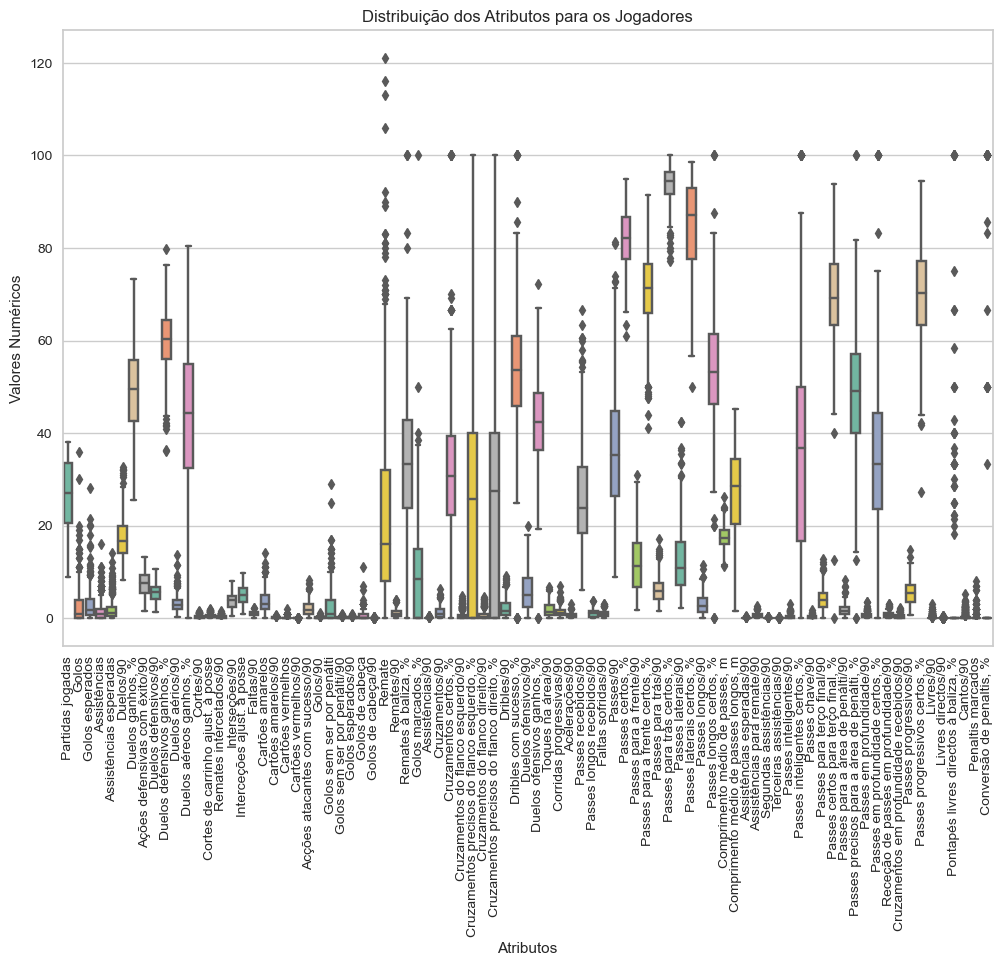

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure o tamanho da figura
plt.figure(figsize=(12, 8))

# Plote os boxplots usando o seaborn
sns.boxplot(data=df_atrib, orient="v", palette="Set2")

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=90)

# Adicione rótulos aos eixos
plt.xlabel("Atributos")
plt.ylabel("Valores Numéricos")

# Adicione um título ao gráfico
plt.title("Distribuição dos Atributos para os Jogadores")

# Mostre o gráfico
plt.show()

In [18]:
from scipy.spatial.distance import euclidean
from itertools import combinations

# Suponha que você já tenha o DataFrame 'df' com os atributos dos jogadores

# Calcule a matriz de distância euclidiana
num_jogadores = len(df)
dist_matrix = np.zeros((num_jogadores, num_jogadores))

# Use itertools.combinations para calcular as distâncias apenas uma vez
for i, j in combinations(range(num_jogadores), 2):
    jogador1 = df_atrib.iloc[i]
    jogador2 = df_atrib.iloc[j]
    dist = euclidean(jogador1, jogador2)
    dist_matrix[i, j] = dist
    dist_matrix[j, i] = dist

# Crie um DataFrame com as distâncias e nomes dos jogadores
dist_df = pd.DataFrame(dist_matrix, columns=df.index, index=df.index)

# Crie uma lista ordenada das células com menor distância
dist_sorted = dist_df.stack().reset_index()
dist_sorted.columns = ['Jogador1', 'Jogador2', 'Distancia']

# Remova os pares de jogadores idênticos (distância zero)
dist_sorted = dist_sorted[dist_sorted['Jogador1'] != dist_sorted['Jogador2']]

# Ordene a lista pelo valor da distância em ordem crescente
dist_sorted = dist_sorted.sort_values(by='Distancia')

# Adicione as informações de jogador e posição
dist_sorted['Jogador1'] = dist_sorted['Jogador1'].apply(lambda x: df['Jogador'].iloc[x])
dist_sorted['Jogador2'] = dist_sorted['Jogador2'].apply(lambda x: df['Jogador'].iloc[x])
# Crie um mapeamento de jogador para posição
jogador_para_posicao = df.set_index('Jogador')['Posição'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted['Posição1'] = dist_sorted['Jogador1'].map(jogador_para_posicao)
dist_sorted['Posição2'] = dist_sorted['Jogador2'].map(jogador_para_posicao)

jogador_para_faixa = df.set_index('Jogador')['faixa_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted['Faixa1'] = dist_sorted['Jogador1'].map(jogador_para_faixa)
dist_sorted['Faixa2'] = dist_sorted['Jogador2'].map(jogador_para_faixa)

jogador_para_grupo = df.set_index('Jogador')['grupo_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted['Grupo1'] = dist_sorted['Jogador1'].map(jogador_para_grupo)
dist_sorted['Grupo2'] = dist_sorted['Jogador2'].map(jogador_para_grupo)

jogador_para_grupoE = df.set_index('Jogador')['grupoE_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted['GrupoE1'] = dist_sorted['Jogador1'].map(jogador_para_grupoE)
dist_sorted['GrupoE2'] = dist_sorted['Jogador2'].map(jogador_para_grupoE)

In [19]:
dist_sorted = dist_sorted.drop_duplicates(subset='Distancia')
dist_sorted

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2
33506,E. Eze,S. Benrahma,29.610683,"[AMF, LCMF, RCMF]","[LAMF, LW, LWF]",[Meias],"[Atacantes, Meias]",[Vol],[Lado],[Meia],[Extremo]
63684,A. Hickey,A. Wan-Bissaka,31.202418,[RB],[RB],[Defensores],[Defensores],[Def],[Def],[Lateral D],[Lateral D]
64185,W. Gnonto,J. Ayew,31.988305,"[LAMF, LWF, RAMF]","[RAMF, CF, LAMF]","[Atacantes, Meias]","[Atacantes, Meias]",[Lado],"[Ata, Lado]",[Extremo],"[Atacante, Extremo]"
62312,Daniel Podence,D. McNeil,32.790232,"[LAMF, AMF, LW]","[LW, RWF]","[Atacantes, Meias]",[Atacantes],"[Vol, Lado]",[Lado],"[Meia, Extremo]",[Extremo]
17237,P. Højbjerg,M. Caicedo,32.945832,"[LCMF, RCMF]","[LCMF, LDMF, RCMF]",[Meias],[Meias],[Vol],[Vol],[Meia],"[Meia, Volante]"
...,...,...,...,...,...,...,...,...,...,...,...
62087,T. Awoniyi,J. Stephens,240.115741,"[CF, LWF]","[RCB, CB]",[Atacantes],[Defensores],"[Ata, Lado]",[Def],"[Atacante, Extremo]",[Zagueiro]
65948,C. Wilson,J. Stephens,241.442424,[CF],"[RCB, CB]",[Atacantes],[Defensores],[Ata],[Def],[Atacante],[Zagueiro]
109369,J. Stephens,D. Ings,241.722730,"[RCB, CB]",[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante]
110525,W. Boly,J. Stephens,246.427762,"[LCB, RCB, CB]","[RCB, CB]",[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]


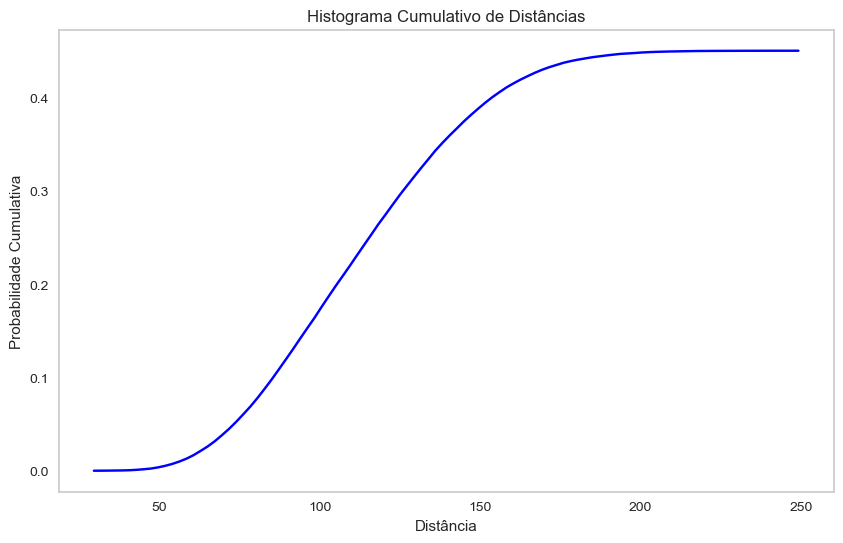

In [27]:
# Suponha que você já tenha o DataFrame 'dist_sorted' com as distâncias ordenadas
distancias = dist_sorted['Distancia']

# Calcule o histograma cumulativo
hist, bins = np.histogram(distancias, bins=100, density=True)
cumulative = np.cumsum(hist)

# Plote o histograma cumulativo
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], cumulative, c='blue')
plt.xlabel('Distância')
plt.ylabel('Probabilidade Cumulativa')
plt.title('Histograma Cumulativo de Distâncias')
plt.grid()
plt.show()

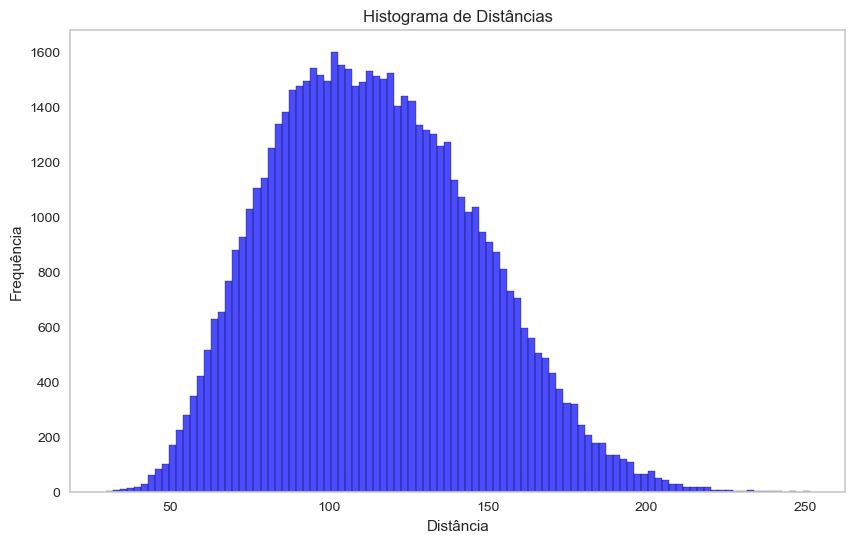

In [28]:
distancias = dist_sorted['Distancia']

# Plote o histograma das distâncias
plt.figure(figsize=(10, 6))
plt.hist(distancias, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Distância')
plt.ylabel('Frequência')
plt.title('Histograma de Distâncias')
plt.grid()
plt.show()

In [29]:
# Suponha que 'dist_sorted' seja o seu DataFrame
nome_do_arquivo = "distancia_jogadores_df_orig.csv"

# Use a função to_csv para salvar o DataFrame em um arquivo CSV
dist_sorted.to_csv(nome_do_arquivo, index=False)

In [30]:
dist_sorted.head(50)

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2,faixa,posicao,grupo,grupoEsp
33506,E. Eze,S. Benrahma,29.610683,"[AMF, LCMF, RCMF]","[LAMF, LW, LWF]",[Meias],"[Atacantes, Meias]",[Vol],[Lado],[Meia],[Extremo],True,False,False,False
63684,A. Hickey,A. Wan-Bissaka,31.202418,[RB],[RB],[Defensores],[Defensores],[Def],[Def],[Lateral D],[Lateral D],True,True,True,True
64185,W. Gnonto,J. Ayew,31.988305,"[LAMF, LWF, RAMF]","[RAMF, CF, LAMF]","[Atacantes, Meias]","[Atacantes, Meias]",[Lado],"[Ata, Lado]",[Extremo],"[Atacante, Extremo]",True,True,True,True
62312,Daniel Podence,D. McNeil,32.790232,"[LAMF, AMF, LW]","[LW, RWF]","[Atacantes, Meias]",[Atacantes],"[Vol, Lado]",[Lado],"[Meia, Extremo]",[Extremo],True,True,True,True
17237,P. Højbjerg,M. Caicedo,32.945832,"[LCMF, RCMF]","[LCMF, LDMF, RCMF]",[Meias],[Meias],[Vol],[Vol],[Meia],"[Meia, Volante]",True,True,True,True
122410,Hugo Bueno,Emerson,32.967373,[LB],"[LB, LWB]",[Defensores],[Defensores],[Def],[Def],[Lateral E],[Lateral E],True,True,True,True
34171,J. Willock,A. Iwobi,33.413851,"[LCMF, RCMF]","[RW, LCMF, RCMF]",[Meias],"[Atacantes, Meias]",[Vol],"[Vol, Lado]",[Meia],"[Meia, Extremo]",True,True,True,True
39787,J. McGinn,A. Iwobi,33.664260,"[RW, RCMF, LCMF]","[RW, LCMF, RCMF]","[Atacantes, Meias]","[Atacantes, Meias]","[Vol, Lado]","[Vol, Lado]","[Meia, Extremo]","[Meia, Extremo]",True,True,True,True
105482,B. De Cordova-Reid,W. Gnonto,34.242682,"[RAMF, RB, LW]","[LAMF, LWF, RAMF]","[Defensores, Meias, Atacantes]","[Atacantes, Meias]","[Def, Lado]",[Lado],"[Lateral D, Extremo]",[Extremo],True,True,True,True
122313,Hugo Bueno,Álex Moreno,34.368774,[LB],[LB],[Defensores],[Defensores],[Def],[Def],[Lateral E],[Lateral E],True,True,True,True


In [31]:
# # Contar a frequência dos valores na coluna
# value_counts = dist_sorted['Distancia'].value_counts()

# # Imprimir os diferentes valores e a quantidade de cada valor
# for value, count in value_counts.items():
#     print(f'Valor: {value}, Quantidade: {count}')

In [32]:
dist_sorted.tail(50)

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2,faixa,posicao,grupo,grupoEsp
109479,J. Stephens,Diego Costa,218.931465,"[RCB, CB]",[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante],False,False,False,False
6629,Mohamed Salah,J. Stephens,218.961887,"[RWF, CF]","[RCB, CB]",[Atacantes],[Defensores],"[Ata, Lado]",[Def],"[Atacante, Extremo]",[Zagueiro],False,False,False,False
54756,E. Konsa,E. Haaland,218.968309,[RCB],[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante],False,False,False,False
114737,C. Kouyaté,J. Stephens,219.190434,[LCMF],"[RCB, CB]",[Meias],[Defensores],[Vol],[Def],[Meia],[Zagueiro],False,False,False,False
58442,T. Adams,T. Awoniyi,219.258762,"[RDMF, LDMF, RCMF]","[CF, LWF]",[Meias],[Atacantes],[Vol],"[Ata, Lado]","[Meia, Volante]","[Atacante, Extremo]",False,False,False,False
54943,E. Konsa,C. Wilson,219.362463,[RCB],[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante],False,False,False,False
109502,J. Stephens,M. Zanka Jørgensen,219.739171,"[RCB, CB]",[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True
119725,M. Zanka Jørgensen,W. Saliba,219.974385,[RCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True
3091,Rodri,J. Mateta,219.987614,"[DMF, RDMF, RCMF]",[CF],[Meias],[Atacantes],[Vol],[Ata],"[Meia, Volante]",[Atacante],False,False,False,False
4914,Rúben Dias,E. Haaland,220.100475,"[LCB, RCB, CB]",[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante],False,False,False,False


In [33]:
# Função para calcular o índice de acerto com base na faixa
def calcular_acerto_faixa(row):
    posicoes_jogador1 = set(row['Faixa1'])
    posicoes_jogador2 = set(row['Faixa2'])
    return bool(posicoes_jogador1.intersection(posicoes_jogador2))

# Função para calcular o índice de acerto com base na posição
def calcular_acerto_posicao(row):
    posicoes_jogador1 = set(row['Posição1'])
    posicoes_jogador2 = set(row['Posição2'])
    return bool(posicoes_jogador1.intersection(posicoes_jogador2))

# Função para calcular o índice de acerto com base no grupo
def calcular_acerto_grupo(row):
    grupos_jogador1 = set(row['Grupo1'])
    grupos_jogador2 = set(row['Grupo2'])
    return bool(grupos_jogador1.intersection(grupos_jogador2))

def calcular_acerto_grupoEsp(row):
    gruposE_jogador1 = set(row['GrupoE1'])
    gruposE_jogador2 = set(row['GrupoE2'])
    return bool(gruposE_jogador1.intersection(gruposE_jogador2))

# Defina o tamanho do intervalo (10.000)
tamanho_intervalo = 10000

# Defina o limite máximo (87.990)
limite_maximo = 76636

# Lista de critérios de comparação
criterios = [
    ('faixa', calcular_acerto_faixa),
    ('posicao', calcular_acerto_posicao),
    ('grupo', calcular_acerto_grupo),
    ('grupoEsp', calcular_acerto_grupoEsp)
]

for criterio_nome, calcular_acerto in criterios:
    print(f"Resultados com base no critério: {criterio_nome.capitalize()}\n")
    
    # Inicialize uma variável para o índice do intervalo
    indice_intervalo = 0

    # Inicialize uma variável para manter o total de acertos
    total_acertos = 0

    # Crie uma nova coluna no DataFrame dist_sorted para o critério atual
    dist_sorted[criterio_nome] = dist_sorted.apply(calcular_acerto, axis=1)

    # Itere sobre os intervalos de 10.000 linhas até o limite máximo
    for i in range(0, limite_maximo, tamanho_intervalo):
        indice_intervalo += 1
        tamanho_real_intervalo = min(tamanho_intervalo, limite_maximo - i)  # Tamanho real do intervalo
        intervalo = dist_sorted.iloc[i:i + tamanho_real_intervalo].copy()  # Copiar o intervalo
        total_acertos_intervalo = intervalo[criterio_nome].sum()  # Somar os acertos parciais
        porcentagem_acerto = (total_acertos_intervalo / tamanho_real_intervalo) * 100
        print(f"Faixa de acerto {indice_intervalo} ({i+1}-{i+tamanho_real_intervalo}): {porcentagem_acerto:.2f}%")

        # Somar os acertos parciais ao total de acertos
        total_acertos += total_acertos_intervalo

    # Calcular a porcentagem de acerto para o intervalo completo com base no critério atual
    porcentagem_acerto_total = (total_acertos / limite_maximo) * 100
    print(f"Porcentagem de acerto total ({criterio_nome.capitalize()}): {porcentagem_acerto_total:.2f}%")
    print("\n" + "=" * 50 + "\n")



Resultados com base no critério: Faixa

Faixa de acerto 1 (1-10000): 60.91%
Faixa de acerto 2 (10001-20000): 53.88%
Faixa de acerto 3 (20001-30000): 49.05%
Faixa de acerto 4 (30001-40000): 48.11%
Faixa de acerto 5 (40001-50000): 44.13%
Faixa de acerto 6 (50001-60000): 33.27%
Faixa de acerto 7 (60001-70000): 3.10%
Faixa de acerto 8 (70001-76636): 0.00%
Porcentagem de acerto total (Faixa): 38.16%


Resultados com base no critério: Posicao

Faixa de acerto 1 (1-10000): 31.14%
Faixa de acerto 2 (10001-20000): 22.17%
Faixa de acerto 3 (20001-30000): 18.92%
Faixa de acerto 4 (30001-40000): 19.83%
Faixa de acerto 5 (40001-50000): 17.91%
Faixa de acerto 6 (50001-60000): 14.27%
Faixa de acerto 7 (60001-70000): 1.81%
Faixa de acerto 8 (70001-76636): 0.00%
Porcentagem de acerto total (Posicao): 16.45%


Resultados com base no critério: Grupo

Faixa de acerto 1 (1-10000): 53.29%
Faixa de acerto 2 (10001-20000): 44.02%
Faixa de acerto 3 (20001-30000): 39.42%
Faixa de acerto 4 (30001-40000): 38.10%


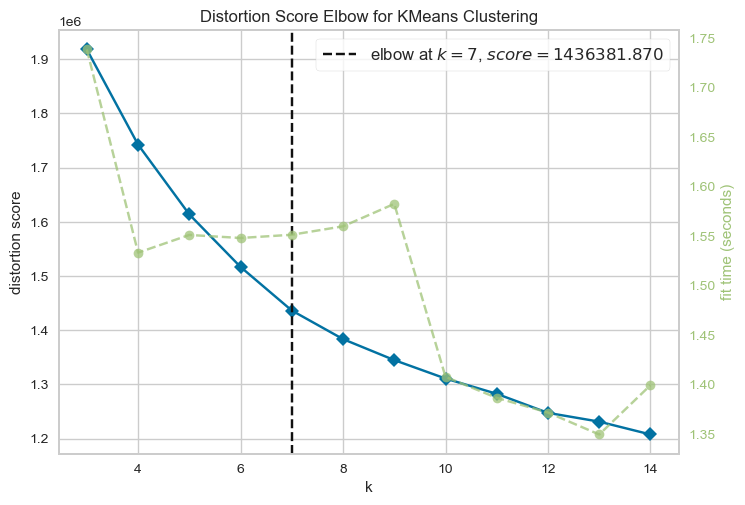

Score para k=5: -1612216.1548124924
Score para k=6: -1516664.4010529139
Score para k=7: -1443369.8197544648
Score para k=8: -1378463.8203389433
Score para k=9: -1341024.4159347727
Score para k=10: -1314669.5249234654
Score para k=11: -1285465.6473835604
Score para k=12: -1253995.1802755964


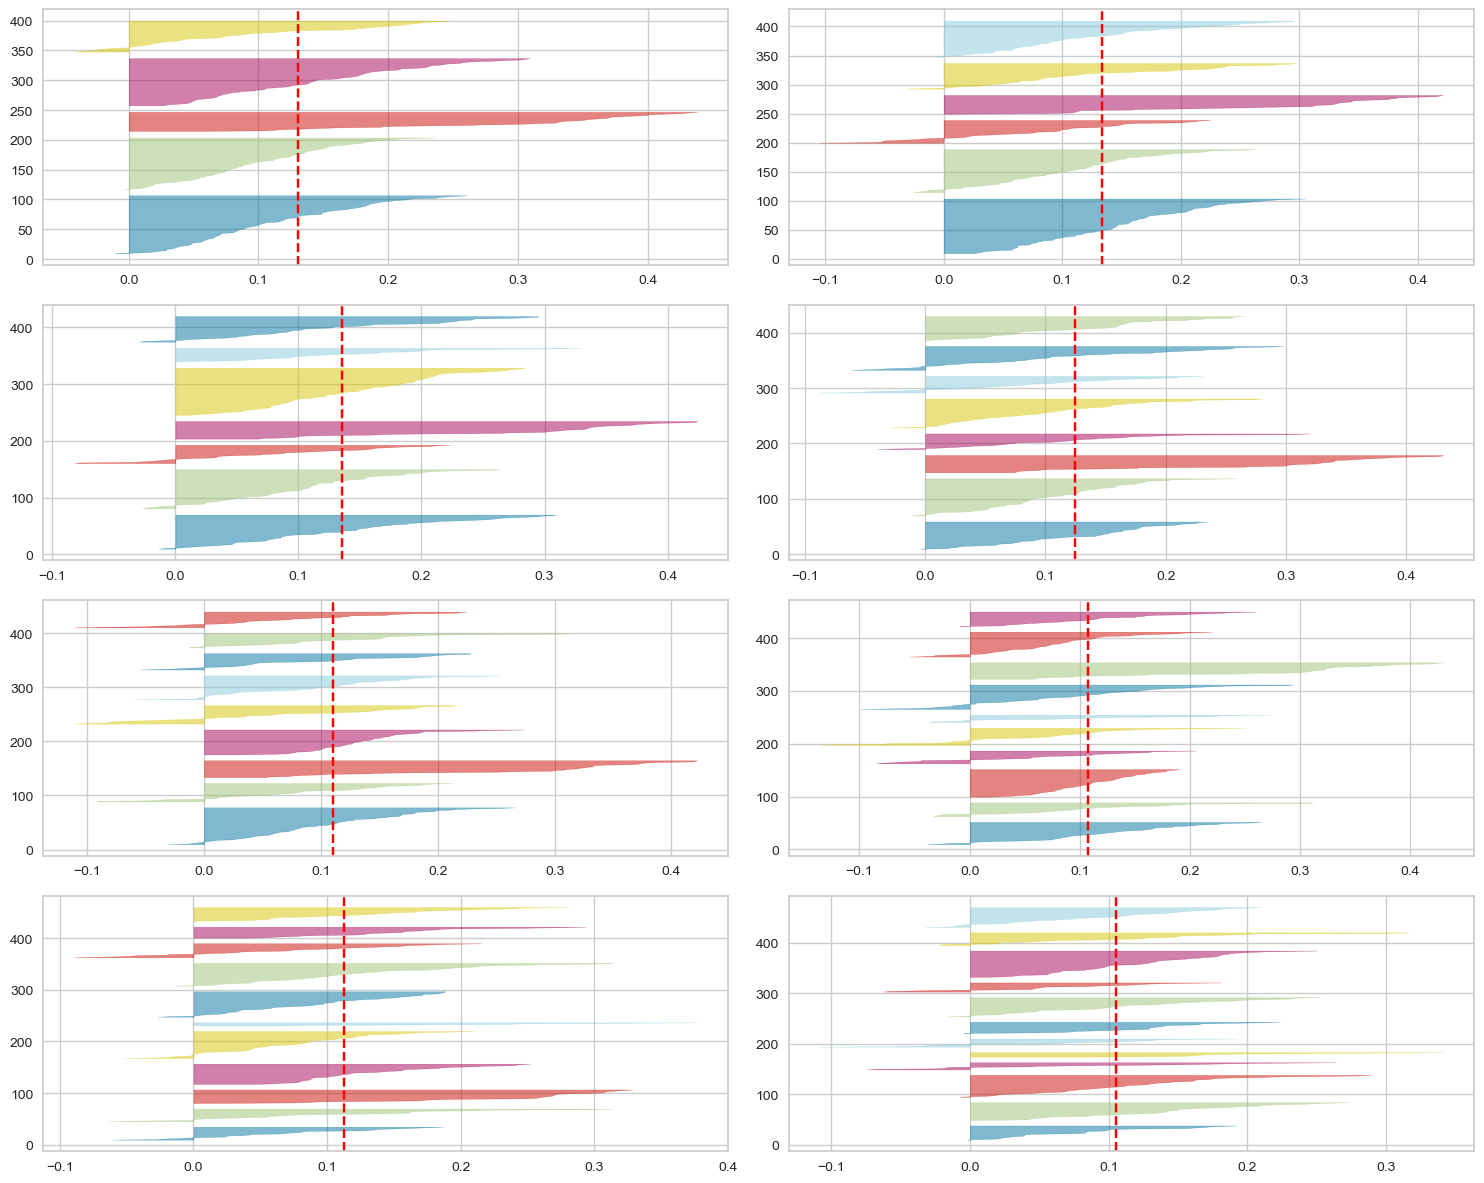

In [34]:
# Load the IRIS dataset
X = df_atrib

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(3,15))
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(4, 2, figsize=(15, 12))
for i, num_clusters in enumerate([5, 6, 7, 8, 9, 10, 11, 12]):
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=100)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(df_atrib)
    
    # Imprimir o score para o valor de k atual
    print(f"Score para k={num_clusters}: {km.score(df_atrib)}")

plt.tight_layout()
plt.show()

# Usando o df original com as colunas numéricas apenas e normalizado Z

In [35]:
scaler = StandardScaler()
df_atrib_normalizado_Z = scaler.fit_transform(df_atrib)
df_atrib_normalizado_Z = pd.DataFrame(df_atrib_normalizado_Z, columns=df_atrib.columns)

In [36]:
# Verificar se há valores vazios em cada coluna
valores_vazios = df_atrib_normalizado_Z.isnull().any()

# Contar a quantidade de valores vazios em cada coluna
qtd_valores_vazios = df_atrib_normalizado_Z.isnull().sum()

# Exibir os resultados
print("Valores vazios em cada coluna:")
print(valores_vazios)

print("\nQuantidade de valores vazios em cada coluna:")
print(qtd_valores_vazios)

Valores vazios em cada coluna:
Partidas jogadas                        False
Golos                                   False
Golos esperados                         False
Assistências                            False
Assistências esperadas                  False
                                        ...  
Livres directos/90                      False
Pontapés livres directos à baliza, %    False
Cantos/90                               False
Penaltis marcados                       False
Conversão de penaltis, %                False
Length: 85, dtype: bool

Quantidade de valores vazios em cada coluna:
Partidas jogadas                        0
Golos                                   0
Golos esperados                         0
Assistências                            0
Assistências esperadas                  0
                                       ..
Livres directos/90                      0
Pontapés livres directos à baliza, %    0
Cantos/90                               0
Penaltis marcad

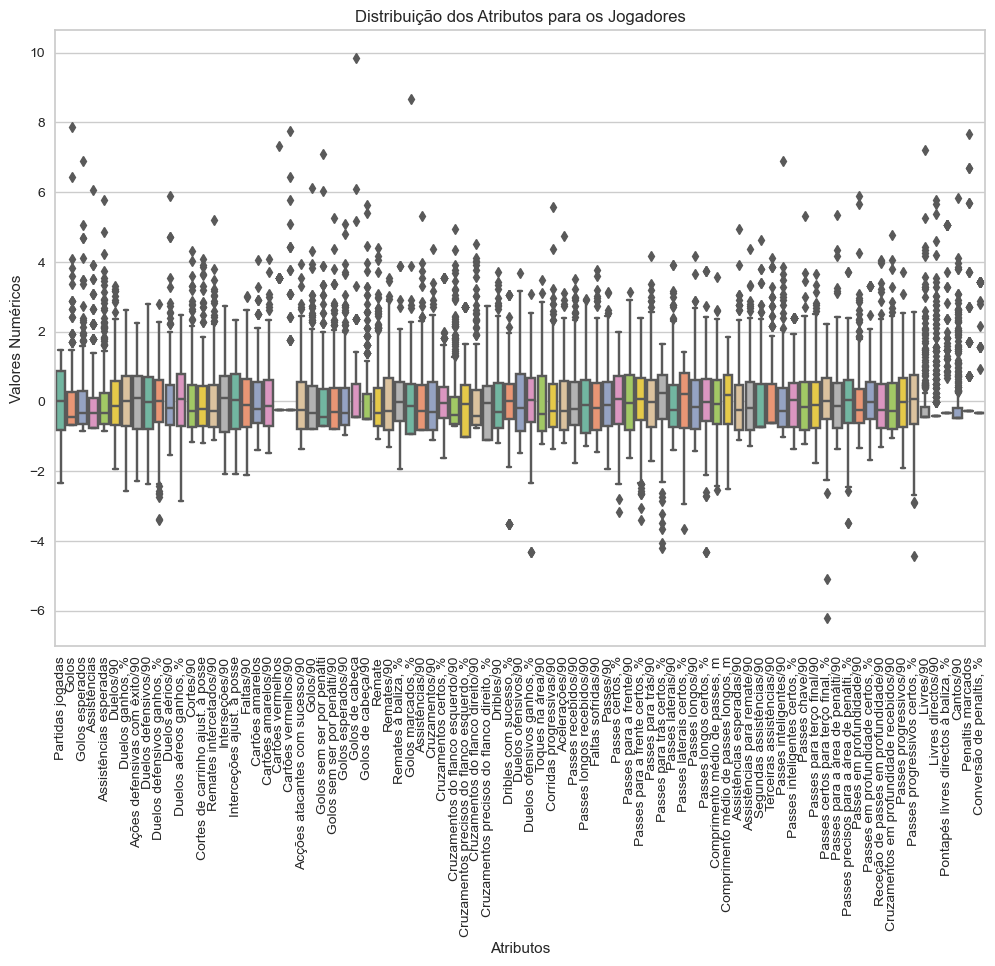

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure o tamanho da figura
plt.figure(figsize=(12, 8))

# Plote os boxplots usando o seaborn
sns.boxplot(data=df_atrib_normalizado_Z, orient="v", palette="Set2")

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=90)

# Adicione rótulos aos eixos
plt.xlabel("Atributos")
plt.ylabel("Valores Numéricos")

# Adicione um título ao gráfico
plt.title("Distribuição dos Atributos para os Jogadores")

# Mostre o gráfico
plt.show()

In [38]:
from scipy.spatial.distance import euclidean
from itertools import combinations

# Suponha que você já tenha o DataFrame 'df' com os atributos dos jogadores

# Calcule a matriz de distância euclidiana
num_jogadores = len(df)
dist_matrix = np.zeros((num_jogadores, num_jogadores))

# Use itertools.combinations para calcular as distâncias apenas uma vez
for i, j in combinations(range(num_jogadores), 2):
    jogador1 = df_atrib_normalizado_Z.iloc[i]
    jogador2 = df_atrib_normalizado_Z.iloc[j]
    dist = euclidean(jogador1, jogador2)
    dist_matrix[i, j] = dist
    dist_matrix[j, i] = dist

# Crie um DataFrame com as distâncias e nomes dos jogadores
dist_df = pd.DataFrame(dist_matrix, columns=df.index, index=df.index)

# Crie uma lista ordenada das células com menor distância
dist_sorted_Z = dist_df.stack().reset_index()
dist_sorted_Z.columns = ['Jogador1', 'Jogador2', 'Distancia']

# Remova os pares de jogadores idênticos (distância zero)
dist_sorted_Z = dist_sorted_Z[dist_sorted_Z['Jogador1'] != dist_sorted_Z['Jogador2']]

# Ordene a lista pelo valor da distância em ordem crescente
dist_sorted_Z = dist_sorted_Z.sort_values(by='Distancia')

# Adicione as informações de jogador e posição
dist_sorted_Z['Jogador1'] = dist_sorted_Z['Jogador1'].apply(lambda x: df['Jogador'].iloc[x])
dist_sorted_Z['Jogador2'] = dist_sorted_Z['Jogador2'].apply(lambda x: df['Jogador'].iloc[x])

# Crie um mapeamento de jogador para posição
jogador_para_posicao = df.set_index('Jogador')['Posição'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted_Z['Posição1'] = dist_sorted_Z['Jogador1'].map(jogador_para_posicao)
dist_sorted_Z['Posição2'] = dist_sorted_Z['Jogador2'].map(jogador_para_posicao)

jogador_para_faixa = df.set_index('Jogador')['faixa_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted_Z['Faixa1'] = dist_sorted_Z['Jogador1'].map(jogador_para_faixa)
dist_sorted_Z['Faixa2'] = dist_sorted_Z['Jogador2'].map(jogador_para_faixa)

jogador_para_grupo = df.set_index('Jogador')['grupo_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted_Z['Grupo1'] =dist_sorted_Z['Jogador1'].map(jogador_para_grupo)
dist_sorted_Z['Grupo2'] = dist_sorted_Z['Jogador2'].map(jogador_para_grupo)

jogador_para_grupoE = df.set_index('Jogador')['grupoE_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted_Z['GrupoE1'] = dist_sorted_Z['Jogador1'].map(jogador_para_grupoE)
dist_sorted_Z['GrupoE2'] = dist_sorted_Z['Jogador2'].map(jogador_para_grupoE)

# Agora, 'dist_sorted' contém a lista ordenada das células com menor distância,
# incluindo o nome do jogador e a posição de cada jogado
dist_sorted_Z = dist_sorted_Z.drop_duplicates(subset='Distancia')
dist_sorted_Z

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2
25042,M. Guéhi,T. Mings,4.141383,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
103728,J. Worrall,R. Koch,4.487231,[RCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
80710,T. Adarabioyo,C. Dawson,4.626376,[RCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
117928,J. Ward,A. Smith,4.642226,"[RB, LB]","[RB, LB]",[Defensores],[Defensores],[Def],[Def],"[Lateral D, Lateral E]","[Lateral D, Lateral E]"
42700,T. Mings,T. Adarabioyo,4.684693,[LCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
...,...,...,...,...,...,...,...,...,...,...,...
47034,H. Maguire,E. Haaland,28.018998,[RCB],[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante]
6,E. Haaland,K. De Bruyne,28.149247,[CF],"[RCMF, AMF]",[Atacantes],[Meias],[Ata],[Vol],[Atacante],[Meia]
2389,K. De Bruyne,J. Mateta,28.342876,"[RCMF, AMF]",[CF],[Meias],[Atacantes],[Vol],[Ata],[Meia],[Atacante]
23,E. Haaland,T. Alexander-Arnold,28.505841,[CF],[RB],[Atacantes],[Defensores],[Ata],[Def],[Atacante],[Lateral D]


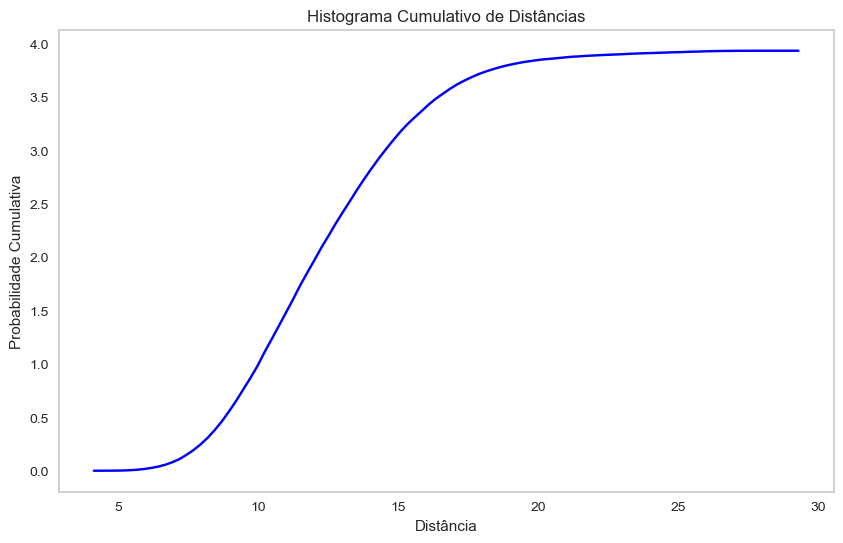

In [39]:
# Suponha que você já tenha o DataFrame 'dist_sorted' com as distâncias ordenadas
distancias = dist_sorted_Z['Distancia']

# Calcule o histograma cumulativo
hist, bins = np.histogram(distancias, bins=100, density=True)
cumulative = np.cumsum(hist)

# Plote o histograma cumulativo
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], cumulative, c='blue')
plt.xlabel('Distância')
plt.ylabel('Probabilidade Cumulativa')
plt.title('Histograma Cumulativo de Distâncias')
plt.grid()
plt.show()

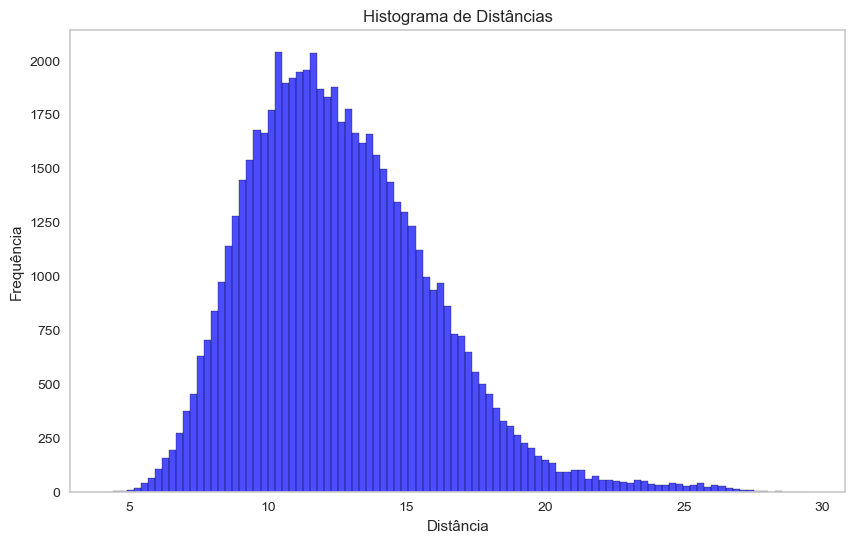

In [40]:
distancias = dist_sorted_Z['Distancia']

# Plote o histograma das distâncias
plt.figure(figsize=(10, 6))
plt.hist(distancias, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Distância')
plt.ylabel('Frequência')
plt.title('Histograma de Distâncias')
plt.grid()
plt.show()

In [41]:
# Suponha que 'dist_sorted' seja o seu DataFrame
nome_do_arquivo = "distancia_jogadores_df_orig_normZ.csv"

# Use a função to_csv para salvar o DataFrame em um arquivo CSV
dist_sorted_Z.to_csv(nome_do_arquivo, index=False)

In [42]:
dist_sorted_Z.head(50)

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2
25042,M. Guéhi,T. Mings,4.141383,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
103728,J. Worrall,R. Koch,4.487231,[RCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
80710,T. Adarabioyo,C. Dawson,4.626376,[RCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
117928,J. Ward,A. Smith,4.642226,"[RB, LB]","[RB, LB]",[Defensores],[Defensores],[Def],[Def],"[Lateral D, Lateral E]","[Lateral D, Lateral E]"
42700,T. Mings,T. Adarabioyo,4.684693,[LCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
117752,J. Ward,P. Struijk,4.701834,"[RB, LB]","[LB, LCB]",[Defensores],[Defensores],[Def],[Def],"[Lateral D, Lateral E]","[Lateral E, Zagueiro]"
18540,Matheus Nunes,R. Christie,4.818334,"[AMF, LW, RCMF]","[RW, AMF, LAMF]","[Atacantes, Meias]","[Atacantes, Meias]","[Vol, Lado]","[Vol, Lado]","[Meia, Extremo]","[Meia, Extremo]"
121567,T. Ream,T. Mings,4.857061,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
121517,T. Ream,M. Guéhi,4.901265,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
46453,E. Dier,T. Mings,4.904887,[CB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]


In [43]:
dist_sorted_Z.tail(50)

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2
67041,L. Dunk,E. Haaland,26.669920,"[LCB, RCB, CB]",[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante]
322,E. Haaland,S. Baptiste,26.673317,[CF],"[RCMF, LCMF]",[Atacantes],[Meias],[Ata],[Vol],[Atacante],[Meia]
74412,L. Kelly,E. Haaland,26.673384,"[LB, LCB]",[CF],[Defensores],[Atacantes],[Def],[Ata],"[Lateral E, Zagueiro]",[Atacante]
113373,Felipe,E. Haaland,26.696251,"[CB, LCB, RCB]",[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante]
59319,A. Bella-Kotchap,E. Haaland,26.712229,"[RCB, LCB]",[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante]
69,E. Haaland,I. Konaté,26.746227,[CF],"[RCB, LCB]",[Atacantes],[Defensores],[Ata],[Def],[Atacante],[Zagueiro]
247,E. Haaland,J. Firpo,26.748225,[CF],[LB],[Atacantes],[Defensores],[Ata],[Def],[Atacante],[Lateral E]
40,E. Haaland,Casemiro,26.755093,[CF],"[RDMF, DMF]",[Atacantes],[Meias],[Ata],[Vol],[Atacante],[Volante]
314,E. Haaland,W. Boly,26.762379,[CF],"[LCB, RCB, CB]",[Atacantes],[Defensores],[Ata],[Def],[Atacante],[Zagueiro]
9477,C. Romero,E. Haaland,26.789481,[RCB],[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante]


In [44]:
# Função para calcular o índice de acerto com base na faixa
def calcular_acerto_faixa(row):
    posicoes_jogador1 = set(row['Faixa1'])
    posicoes_jogador2 = set(row['Faixa2'])
    return bool(posicoes_jogador1.intersection(posicoes_jogador2))

# Função para calcular o índice de acerto com base na posição
def calcular_acerto_posicao(row):
    posicoes_jogador1 = set(row['Posição1'])
    posicoes_jogador2 = set(row['Posição2'])
    return bool(posicoes_jogador1.intersection(posicoes_jogador2))

# Função para calcular o índice de acerto com base no grupo
def calcular_acerto_grupo(row):
    grupos_jogador1 = set(row['Grupo1'])
    grupos_jogador2 = set(row['Grupo2'])
    return bool(grupos_jogador1.intersection(grupos_jogador2))

def calcular_acerto_grupoEsp(row):
    gruposE_jogador1 = set(row['GrupoE1'])
    gruposE_jogador2 = set(row['GrupoE2'])
    return bool(gruposE_jogador1.intersection(gruposE_jogador2))

# Defina o tamanho do intervalo (10.000)
tamanho_intervalo = 10000

# Defina o limite máximo (87.990)
limite_maximo = 76636

# Lista de critérios de comparação
criterios = [
    ('faixa', calcular_acerto_faixa),
    ('posicao', calcular_acerto_posicao),
    ('grupo', calcular_acerto_grupo),
    ('grupoEsp', calcular_acerto_grupoEsp)
]

for criterio_nome, calcular_acerto in criterios:
    print(f"Resultados com base no critério: {criterio_nome.capitalize()}\n")
    
    # Inicialize uma variável para o índice do intervalo
    indice_intervalo = 0

    # Inicialize uma variável para manter o total de acertos
    total_acertos = 0

    # Crie uma nova coluna no DataFrame dist_sorted para o critério atual
    dist_sorted_Z[criterio_nome] = dist_sorted_Z.apply(calcular_acerto, axis=1)

    # Itere sobre os intervalos de 10.000 linhas até o limite máximo
    for i in range(0, limite_maximo, tamanho_intervalo):
        indice_intervalo += 1
        tamanho_real_intervalo = min(tamanho_intervalo, limite_maximo - i)  # Tamanho real do intervalo
        intervalo = dist_sorted_Z.iloc[i:i + tamanho_real_intervalo].copy()  # Copiar o intervalo
        total_acertos_intervalo = intervalo[criterio_nome].sum()  # Somar os acertos parciais
        porcentagem_acerto = (total_acertos_intervalo / tamanho_real_intervalo) * 100
        print(f"Faixa de acerto {indice_intervalo} ({i+1}-{i+tamanho_real_intervalo}): {porcentagem_acerto:.2f}%")

        # Somar os acertos parciais ao total de acertos
        total_acertos += total_acertos_intervalo

    # Calcular a porcentagem de acerto para o intervalo completo com base no critério atual
    porcentagem_acerto_total = (total_acertos / limite_maximo) * 100
    print(f"Porcentagem de acerto total ({criterio_nome.capitalize()}): {porcentagem_acerto_total:.2f}%")
    print("\n" + "=" * 50 + "\n")



Resultados com base no critério: Faixa

Faixa de acerto 1 (1-10000): 68.90%
Faixa de acerto 2 (10001-20000): 59.95%
Faixa de acerto 3 (20001-30000): 52.96%
Faixa de acerto 4 (30001-40000): 45.77%
Faixa de acerto 5 (40001-50000): 35.45%
Faixa de acerto 6 (50001-60000): 26.45%
Faixa de acerto 7 (60001-70000): 2.97%
Faixa de acerto 8 (70001-76636): 0.00%
Porcentagem de acerto total (Faixa): 38.16%


Resultados com base no critério: Posicao

Faixa de acerto 1 (1-10000): 43.36%
Faixa de acerto 2 (10001-20000): 29.79%
Faixa de acerto 3 (20001-30000): 21.82%
Faixa de acerto 4 (30001-40000): 15.44%
Faixa de acerto 5 (40001-50000): 9.38%
Faixa de acerto 6 (50001-60000): 4.98%
Faixa de acerto 7 (60001-70000): 1.28%
Faixa de acerto 8 (70001-76636): 0.00%
Porcentagem de acerto total (Posicao): 16.45%


Resultados com base no critério: Grupo

Faixa de acerto 1 (1-10000): 66.52%
Faixa de acerto 2 (10001-20000): 53.95%
Faixa de acerto 3 (20001-30000): 43.10%
Faixa de acerto 4 (30001-40000): 33.80%
Fa

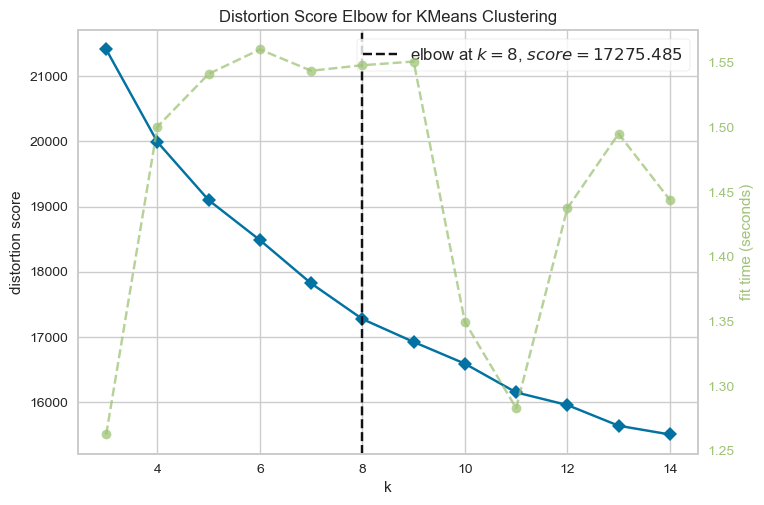

Score para k=5: -19092.81164278528
Score para k=6: -18466.88007327826
Score para k=7: -17840.864640782926
Score para k=8: -17318.25779131978
Score para k=9: -16909.810420004887
Score para k=10: -16667.05969840197
Score para k=11: -16291.03038494287
Score para k=12: -15980.535095085008


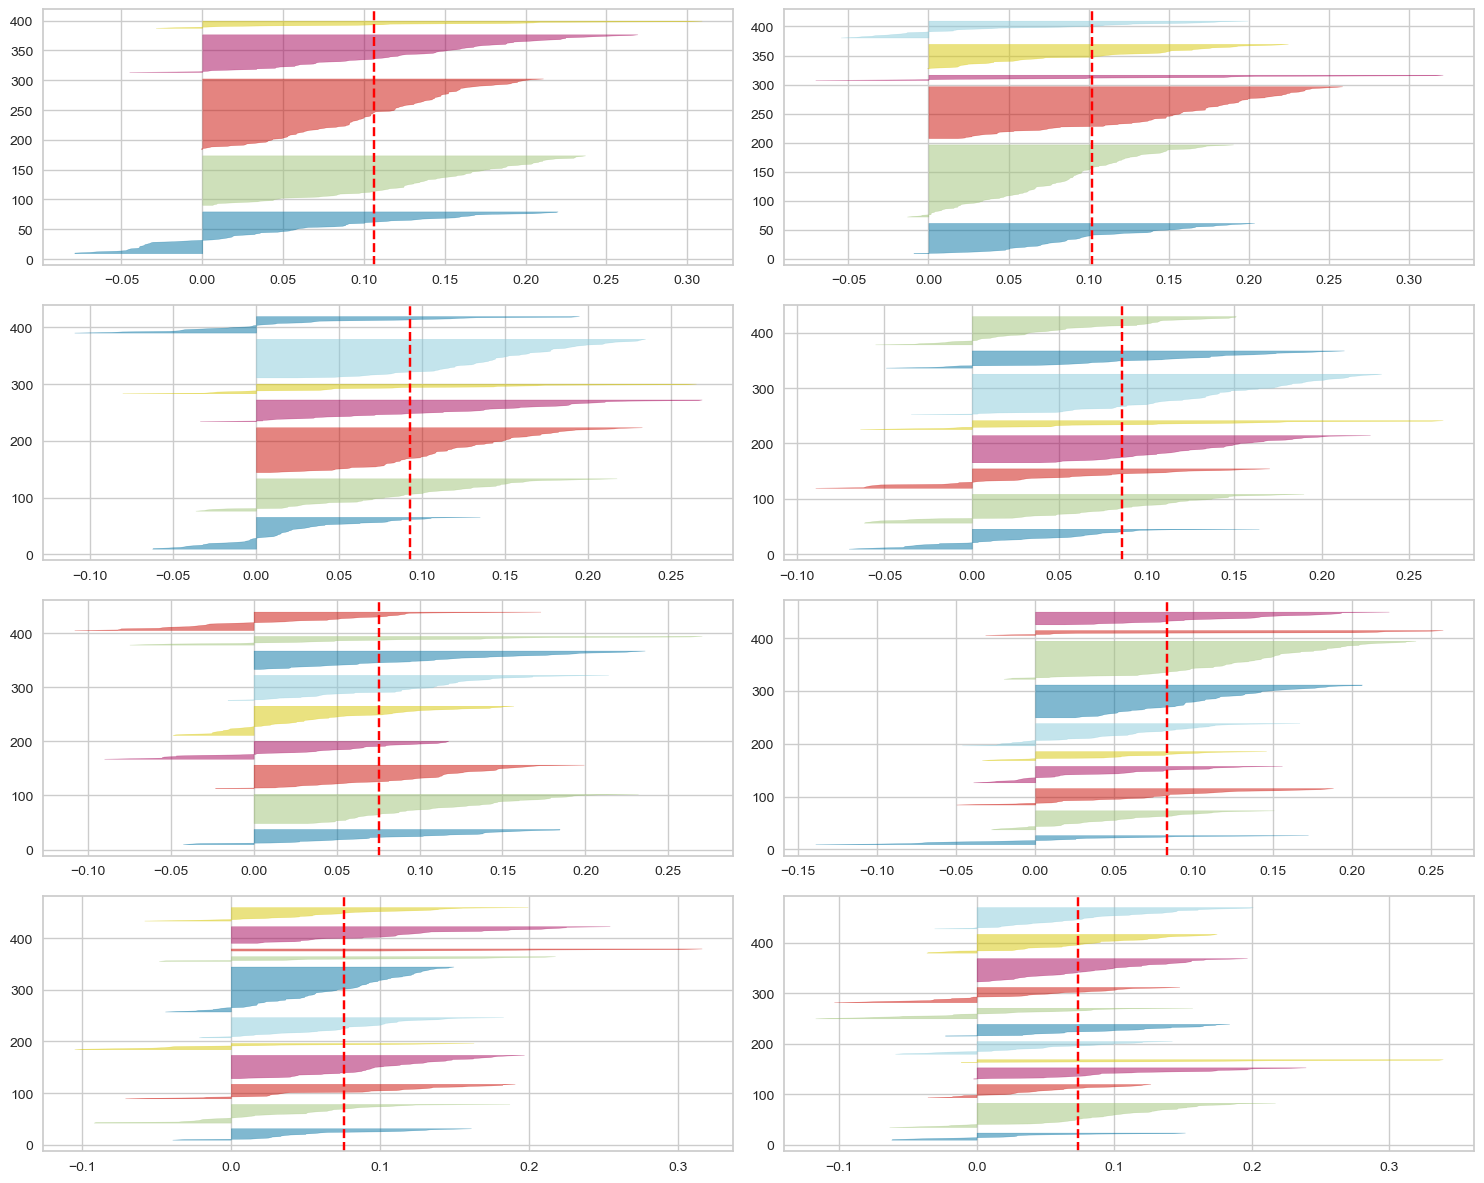

In [45]:
# Load the IRIS dataset
X = df_atrib_normalizado_Z

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(3,15))
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(4, 2, figsize=(15, 12))
for i, num_clusters in enumerate([5, 6, 7, 8, 9, 10, 11, 12]):
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=100)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(df_atrib_normalizado_Z)
    
    # Imprimir o score para o valor de k atual
    print(f"Score para k={num_clusters}: {km.score(df_atrib_normalizado_Z)}")

plt.tight_layout()
plt.show()

# Usando o df original com as colunas numéricas apenas e normalizado minmax

In [46]:
min_max_scaler = preprocessing.MinMaxScaler()
df_atrib_normalizadoMinMax = min_max_scaler.fit_transform(df_atrib)
df_atrib_normalizadoMinMax = pd.DataFrame(df_atrib_normalizadoMinMax, columns=df_atrib.columns)

# Preencher valores nulos com 0

df_atrib_normalizadoMinMax = df_atrib_normalizadoMinMax.fillna(0)

In [47]:
# Verificar se há valores vazios em cada coluna
valores_vazios = df_atrib_normalizadoMinMax.isnull().any()

# Contar a quantidade de valores vazios em cada coluna
qtd_valores_vazios = df_atrib_normalizadoMinMax.isnull().sum()

# Exibir os resultados
print("Valores vazios em cada coluna:")
print(valores_vazios)

print("\nQuantidade de valores vazios em cada coluna:")
print(qtd_valores_vazios)

Valores vazios em cada coluna:
Partidas jogadas                        False
Golos                                   False
Golos esperados                         False
Assistências                            False
Assistências esperadas                  False
                                        ...  
Livres directos/90                      False
Pontapés livres directos à baliza, %    False
Cantos/90                               False
Penaltis marcados                       False
Conversão de penaltis, %                False
Length: 85, dtype: bool

Quantidade de valores vazios em cada coluna:
Partidas jogadas                        0
Golos                                   0
Golos esperados                         0
Assistências                            0
Assistências esperadas                  0
                                       ..
Livres directos/90                      0
Pontapés livres directos à baliza, %    0
Cantos/90                               0
Penaltis marcad

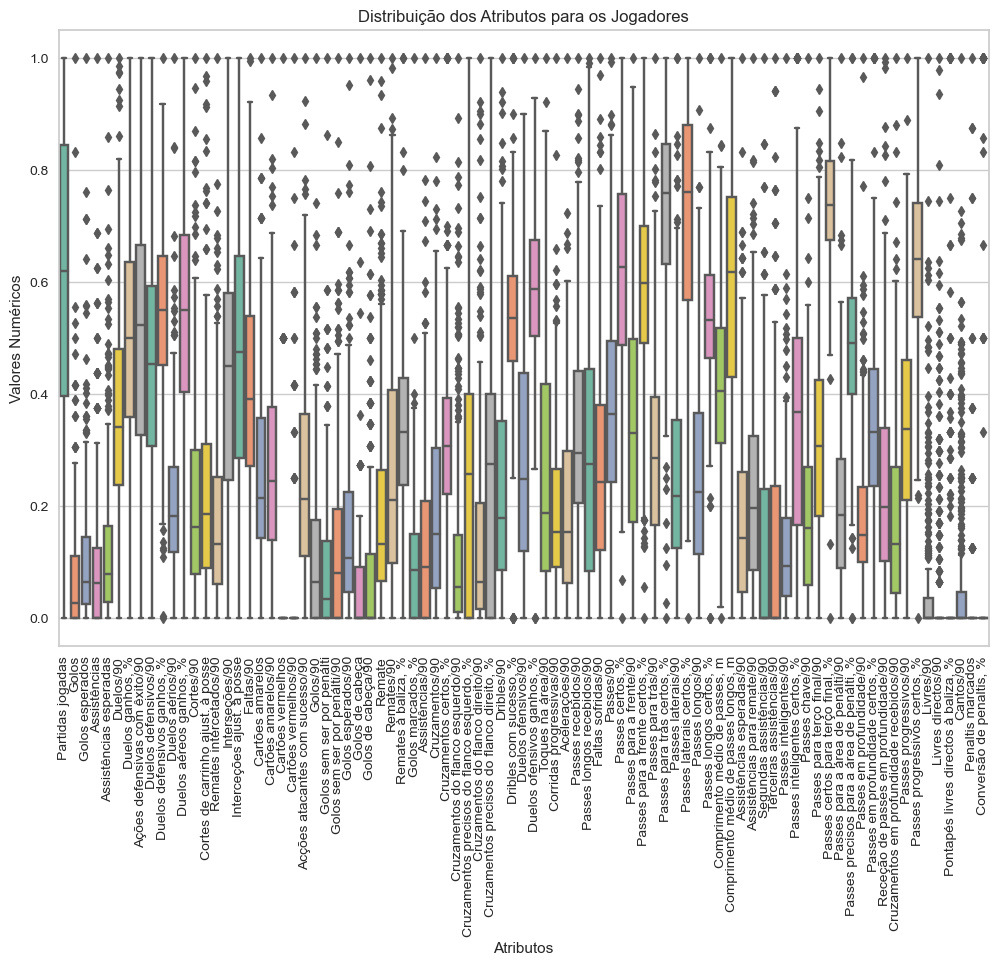

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure o tamanho da figura
plt.figure(figsize=(12, 8))

# Plote os boxplots usando o seaborn
sns.boxplot(data=df_atrib_normalizadoMinMax, orient="v", palette="Set2")

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=90)

# Adicione rótulos aos eixos
plt.xlabel("Atributos")
plt.ylabel("Valores Numéricos")

# Adicione um título ao gráfico
plt.title("Distribuição dos Atributos para os Jogadores")

# Mostre o gráfico
plt.show()

In [49]:
from scipy.spatial.distance import euclidean
from itertools import combinations

# Suponha que você já tenha o DataFrame 'df' com os atributos dos jogadores

# Calcule a matriz de distância euclidiana
num_jogadores = len(df)
dist_matrix = np.zeros((num_jogadores, num_jogadores))

# Use itertools.combinations para calcular as distâncias apenas uma vez
for i, j in combinations(range(num_jogadores), 2):
    jogador1 = df_atrib_normalizadoMinMax.iloc[i]
    jogador2 = df_atrib_normalizadoMinMax.iloc[j]
    dist = euclidean(jogador1, jogador2)
    dist_matrix[i, j] = dist
    dist_matrix[j, i] = dist

# Crie um DataFrame com as distâncias e nomes dos jogadores
dist_df = pd.DataFrame(dist_matrix, columns=df.index, index=df.index)

# Crie uma lista ordenada das células com menor distância
dist_sorted_MM = dist_df.stack().reset_index()
dist_sorted_MM.columns = ['Jogador1', 'Jogador2', 'Distancia']

# Remova os pares de jogadores idênticos (distância zero)
dist_sorted_MM = dist_sorted_MM[dist_sorted_MM['Jogador1'] != dist_sorted_MM['Jogador2']]

# Ordene a lista pelo valor da distância em ordem crescente
dist_sorted_MM = dist_sorted_MM.sort_values(by='Distancia')

# Adicione as informações de jogador e posição
dist_sorted_MM['Jogador1'] = dist_sorted_MM['Jogador1'].apply(lambda x: df['Jogador'].iloc[x])
dist_sorted_MM['Jogador2'] = dist_sorted_MM['Jogador2'].apply(lambda x: df['Jogador'].iloc[x])

# Crie um mapeamento de jogador para posição
jogador_para_posicao = df.set_index('Jogador')['Posição'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted_MM['Posição1'] = dist_sorted_MM['Jogador1'].map(jogador_para_posicao)
dist_sorted_MM['Posição2'] = dist_sorted_MM['Jogador2'].map(jogador_para_posicao)

jogador_para_faixa = df.set_index('Jogador')['faixa_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted_MM['Faixa1'] = dist_sorted_MM['Jogador1'].map(jogador_para_faixa)
dist_sorted_MM['Faixa2'] = dist_sorted_MM['Jogador2'].map(jogador_para_faixa)

jogador_para_grupo = df.set_index('Jogador')['grupo_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted_MM['Grupo1'] = dist_sorted_MM['Jogador1'].map(jogador_para_grupo)
dist_sorted_MM['Grupo2'] = dist_sorted_MM['Jogador2'].map(jogador_para_grupo)

jogador_para_grupoE = df.set_index('Jogador')['grupoE_atuação'].to_dict()

# Adicione as informações de jogador e posição
dist_sorted_MM['GrupoE1'] = dist_sorted_MM['Jogador1'].map(jogador_para_grupoE)
dist_sorted_MM['GrupoE2'] = dist_sorted_MM['Jogador2'].map(jogador_para_grupoE)
# Agora, 'dist_sorted' contém a lista ordenada das células com menor distância,
# incluindo o nome do jogador e a posição de cada jogado
dist_sorted_MM = dist_sorted_MM.drop_duplicates(subset='Distancia')
dist_sorted_MM

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2
25042,M. Guéhi,T. Mings,0.753847,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
80710,T. Adarabioyo,C. Dawson,0.774755,[RCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
121517,T. Ream,M. Guéhi,0.814141,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
42817,T. Mings,T. Ream,0.824874,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro]
120728,A. Smith,J. Ward,0.837960,"[RB, LB]","[RB, LB]",[Defensores],[Defensores],[Def],[Def],"[Lateral D, Lateral E]","[Lateral D, Lateral E]"
...,...,...,...,...,...,...,...,...,...,...,...
99339,J. Mateta,K. De Bruyne,4.524574,[CF],"[RCMF, AMF]",[Atacantes],[Meias],[Ata],[Vol],[Atacante],[Meia]
4914,Rúben Dias,E. Haaland,4.529340,"[LCB, RCB, CB]",[CF],[Defensores],[Atacantes],[Def],[Ata],[Zagueiro],[Atacante]
65988,Thiago Alcântara,E. Haaland,4.540277,[LCMF],[CF],[Meias],[Atacantes],[Vol],[Ata],[Meia],[Atacante]
8073,T. Alexander-Arnold,E. Haaland,4.589375,[RB],[CF],[Defensores],[Atacantes],[Def],[Ata],[Lateral D],[Atacante]


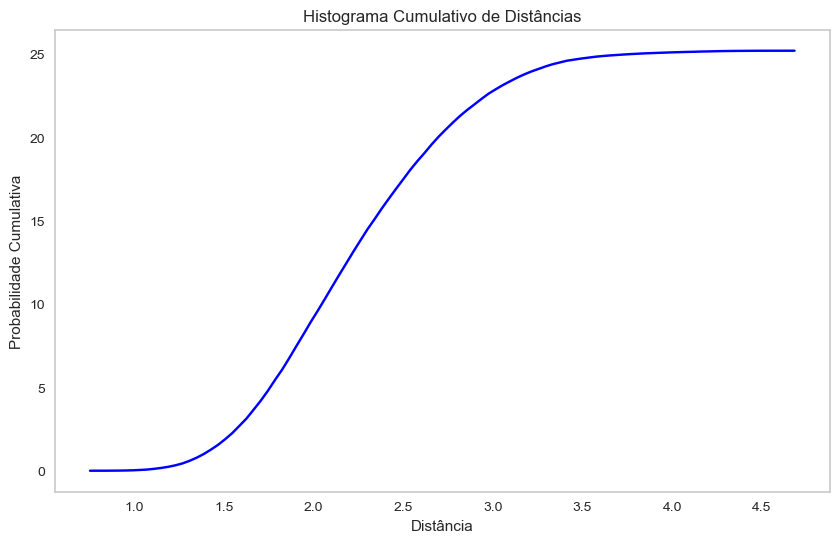

In [50]:
# Suponha que você já tenha o DataFrame 'dist_sorted' com as distâncias ordenadas
distancias = dist_sorted_MM['Distancia']

# Calcule o histograma cumulativo
hist, bins = np.histogram(distancias, bins=100, density=True)
cumulative = np.cumsum(hist)

# Plote o histograma cumulativo
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], cumulative, c='blue')
plt.xlabel('Distância')
plt.ylabel('Probabilidade Cumulativa')
plt.title('Histograma Cumulativo de Distâncias')
plt.grid()
plt.show()

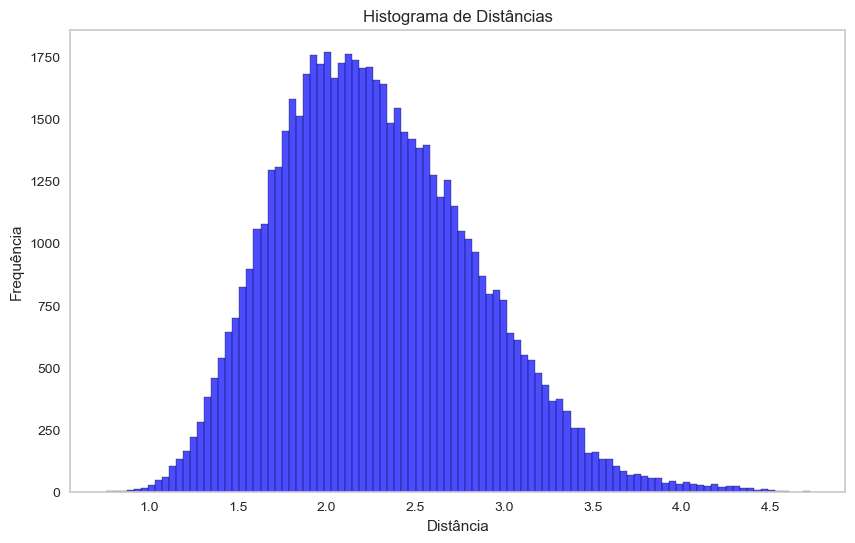

In [51]:
distancias = dist_sorted_MM['Distancia']

# Plote o histograma das distâncias
plt.figure(figsize=(10, 6))
plt.hist(distancias, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Distância')
plt.ylabel('Frequência')
plt.title('Histograma de Distâncias')
plt.grid()
plt.show()

In [52]:
# Suponha que 'dist_sorted' seja o seu DataFrame
nome_do_arquivo = "distancia_jogadores_df_orig_normMM.csv"

# Use a função to_csv para salvar o DataFrame em um arquivo CSV
dist_sorted_MM.to_csv(nome_do_arquivo, index=False)

In [53]:
# Função para calcular o índice de acerto com base na faixa
def calcular_acerto_faixa(row):
    posicoes_jogador1 = set(row['Faixa1'])
    posicoes_jogador2 = set(row['Faixa2'])
    return bool(posicoes_jogador1.intersection(posicoes_jogador2))

# Função para calcular o índice de acerto com base na posição
def calcular_acerto_posicao(row):
    posicoes_jogador1 = set(row['Posição1'])
    posicoes_jogador2 = set(row['Posição2'])
    return bool(posicoes_jogador1.intersection(posicoes_jogador2))

# Função para calcular o índice de acerto com base no grupo
def calcular_acerto_grupo(row):
    grupos_jogador1 = set(row['Grupo1'])
    grupos_jogador2 = set(row['Grupo2'])
    return bool(grupos_jogador1.intersection(grupos_jogador2))

def calcular_acerto_grupoEsp(row):
    gruposE_jogador1 = set(row['GrupoE1'])
    gruposE_jogador2 = set(row['GrupoE2'])
    return bool(gruposE_jogador1.intersection(gruposE_jogador2))

# Defina o tamanho do intervalo (10.000)
tamanho_intervalo = 10000

# Defina o limite máximo (87.990)
limite_maximo = 76636

# Lista de critérios de comparação
criterios = [
    ('faixa', calcular_acerto_faixa),
    ('posicao', calcular_acerto_posicao),
    ('grupo', calcular_acerto_grupo),
    ('grupoEsp', calcular_acerto_grupoEsp)
]

for criterio_nome, calcular_acerto in criterios:
    print(f"Resultados com base no critério: {criterio_nome.capitalize()}\n")
    
    # Inicialize uma variável para o índice do intervalo
    indice_intervalo = 0

    # Inicialize uma variável para manter o total de acertos
    total_acertos = 0

    # Crie uma nova coluna no DataFrame dist_sorted para o critério atual
    dist_sorted_MM[criterio_nome] = dist_sorted_MM.apply(calcular_acerto, axis=1)

    # Itere sobre os intervalos de 10.000 linhas até o limite máximo
    for i in range(0, limite_maximo, tamanho_intervalo):
        indice_intervalo += 1
        tamanho_real_intervalo = min(tamanho_intervalo, limite_maximo - i)  # Tamanho real do intervalo
        intervalo = dist_sorted_MM.iloc[i:i + tamanho_real_intervalo].copy()  # Copiar o intervalo
        total_acertos_intervalo = intervalo[criterio_nome].sum()  # Somar os acertos parciais
        porcentagem_acerto = (total_acertos_intervalo / tamanho_real_intervalo) * 100
        print(f"Faixa de acerto {indice_intervalo} ({i+1}-{i+tamanho_real_intervalo}): {porcentagem_acerto:.2f}%")

        # Somar os acertos parciais ao total de acertos
        total_acertos += total_acertos_intervalo

    # Calcular a porcentagem de acerto para o intervalo completo com base no critério atual
    porcentagem_acerto_total = (total_acertos / limite_maximo) * 100
    print(f"Porcentagem de acerto total ({criterio_nome.capitalize()}): {porcentagem_acerto_total:.2f}%")
    print("\n" + "=" * 50 + "\n")



Resultados com base no critério: Faixa

Faixa de acerto 1 (1-10000): 69.79%
Faixa de acerto 2 (10001-20000): 60.09%
Faixa de acerto 3 (20001-30000): 55.22%
Faixa de acerto 4 (30001-40000): 46.86%
Faixa de acerto 5 (40001-50000): 35.45%
Faixa de acerto 6 (50001-60000): 23.32%
Faixa de acerto 7 (60001-70000): 1.72%
Faixa de acerto 8 (70001-76636): 0.00%
Porcentagem de acerto total (Faixa): 38.16%


Resultados com base no critério: Posicao

Faixa de acerto 1 (1-10000): 44.11%
Faixa de acerto 2 (10001-20000): 30.37%
Faixa de acerto 3 (20001-30000): 23.76%
Faixa de acerto 4 (30001-40000): 15.34%
Faixa de acerto 5 (40001-50000): 8.15%
Faixa de acerto 6 (50001-60000): 3.69%
Faixa de acerto 7 (60001-70000): 0.63%
Faixa de acerto 8 (70001-76636): 0.00%
Porcentagem de acerto total (Posicao): 16.45%


Resultados com base no critério: Grupo

Faixa de acerto 1 (1-10000): 67.02%
Faixa de acerto 2 (10001-20000): 53.85%
Faixa de acerto 3 (20001-30000): 45.05%
Faixa de acerto 4 (30001-40000): 34.94%
Fa

In [54]:
dist_sorted_MM.head(50)

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2,faixa,posicao,grupo,grupoEsp
25042,M. Guéhi,T. Mings,0.753847,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True
80710,T. Adarabioyo,C. Dawson,0.774755,[RCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True
121517,T. Ream,M. Guéhi,0.814141,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True
42817,T. Mings,T. Ream,0.824874,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True
120728,A. Smith,J. Ward,0.837960,"[RB, LB]","[RB, LB]",[Defensores],[Defensores],[Def],[Def],"[Lateral D, Lateral E]","[Lateral D, Lateral E]",True,True,True,True
88951,D. Burn,V. Mykolenko,0.873543,[LB],"[LB, LWB]",[Defensores],[Defensores],[Def],[Def],[Lateral E],[Lateral E],True,True,True,True
42700,T. Mings,T. Adarabioyo,0.879599,[LCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,False,True,True
103728,J. Worrall,R. Koch,0.888511,[RCB],[RCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True
67927,I. Diop,C. Coady,0.891428,"[RCB, LCB]","[RCB, CB]",[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True
14863,Gabriel Magalhaes,T. Mings,0.900159,[LCB],[LCB],[Defensores],[Defensores],[Def],[Def],[Zagueiro],[Zagueiro],True,True,True,True


In [55]:
dist_sorted_MM.tail(50)

,Jogador1,Jogador2,Distancia,Posição1,Posição2,Faixa1,Faixa2,Grupo1,Grupo2,GrupoE1,GrupoE2,faixa,posicao,grupo,grupoEsp
2253,K. De Bruyne,J. Tarkowski,4.328735,"[RCMF, AMF]",[LCB],[Meias],[Defensores],[Vol],[Def],[Meia],[Zagueiro],False,False,False,False
4920,Rúben Dias,K. De Bruyne,4.329363,"[LCB, RCB, CB]","[RCMF, AMF]",[Defensores],[Meias],[Def],[Vol],[Zagueiro],[Meia],False,False,False,False
30,E. Haaland,João Cancelo,4.332176,[CF],[LB],[Atacantes],[Defensores],[Ata],[Def],[Atacante],[Lateral E],False,False,False,False
2216,K. De Bruyne,A. Mitrović,4.337328,"[RCMF, AMF]",[CF],[Meias],[Atacantes],[Vol],[Ata],[Meia],[Atacante],False,False,False,False
2231,K. De Bruyne,D. Calvert-Lewin,4.346890,"[RCMF, AMF]",[CF],[Meias],[Atacantes],[Vol],[Ata],[Meia],[Atacante],False,False,False,False
113379,Felipe,K. De Bruyne,4.348071,"[CB, LCB, RCB]","[RCMF, AMF]",[Defensores],[Meias],[Def],[Vol],[Zagueiro],[Meia],False,False,False,False
2431,K. De Bruyne,J. Evans,4.350064,"[RCMF, AMF]","[LCB, CB, RCB]",[Meias],[Defensores],[Vol],[Def],[Meia],[Zagueiro],False,False,False,False
117936,J. Milner,E. Haaland,4.350328,"[LCMF, RB, RCMF]",[CF],"[Defensores, Meias]",[Atacantes],"[Vol, Def]",[Ata],"[Lateral D, Meia]",[Atacante],False,False,False,False
66339,K. Tsimikas,E. Haaland,4.356841,[LB],[CF],[Defensores],[Atacantes],[Def],[Ata],[Lateral E],[Atacante],False,False,False,False
107763,L. Cooper,K. De Bruyne,4.360509,[LCB],"[RCMF, AMF]",[Defensores],[Meias],[Def],[Vol],[Zagueiro],[Meia],False,False,False,False


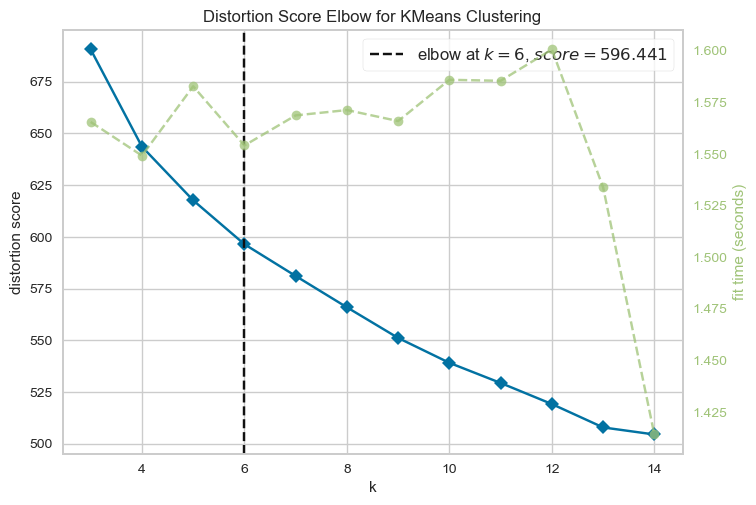

Score para k=5: -618.6779333907049
Score para k=6: -596.2811928722045
Score para k=7: -579.8210710423862
Score para k=8: -563.9987654052311
Score para k=9: -548.0848694204504
Score para k=10: -539.3986775709924
Score para k=11: -529.2732808899456
Score para k=12: -520.6693156402716


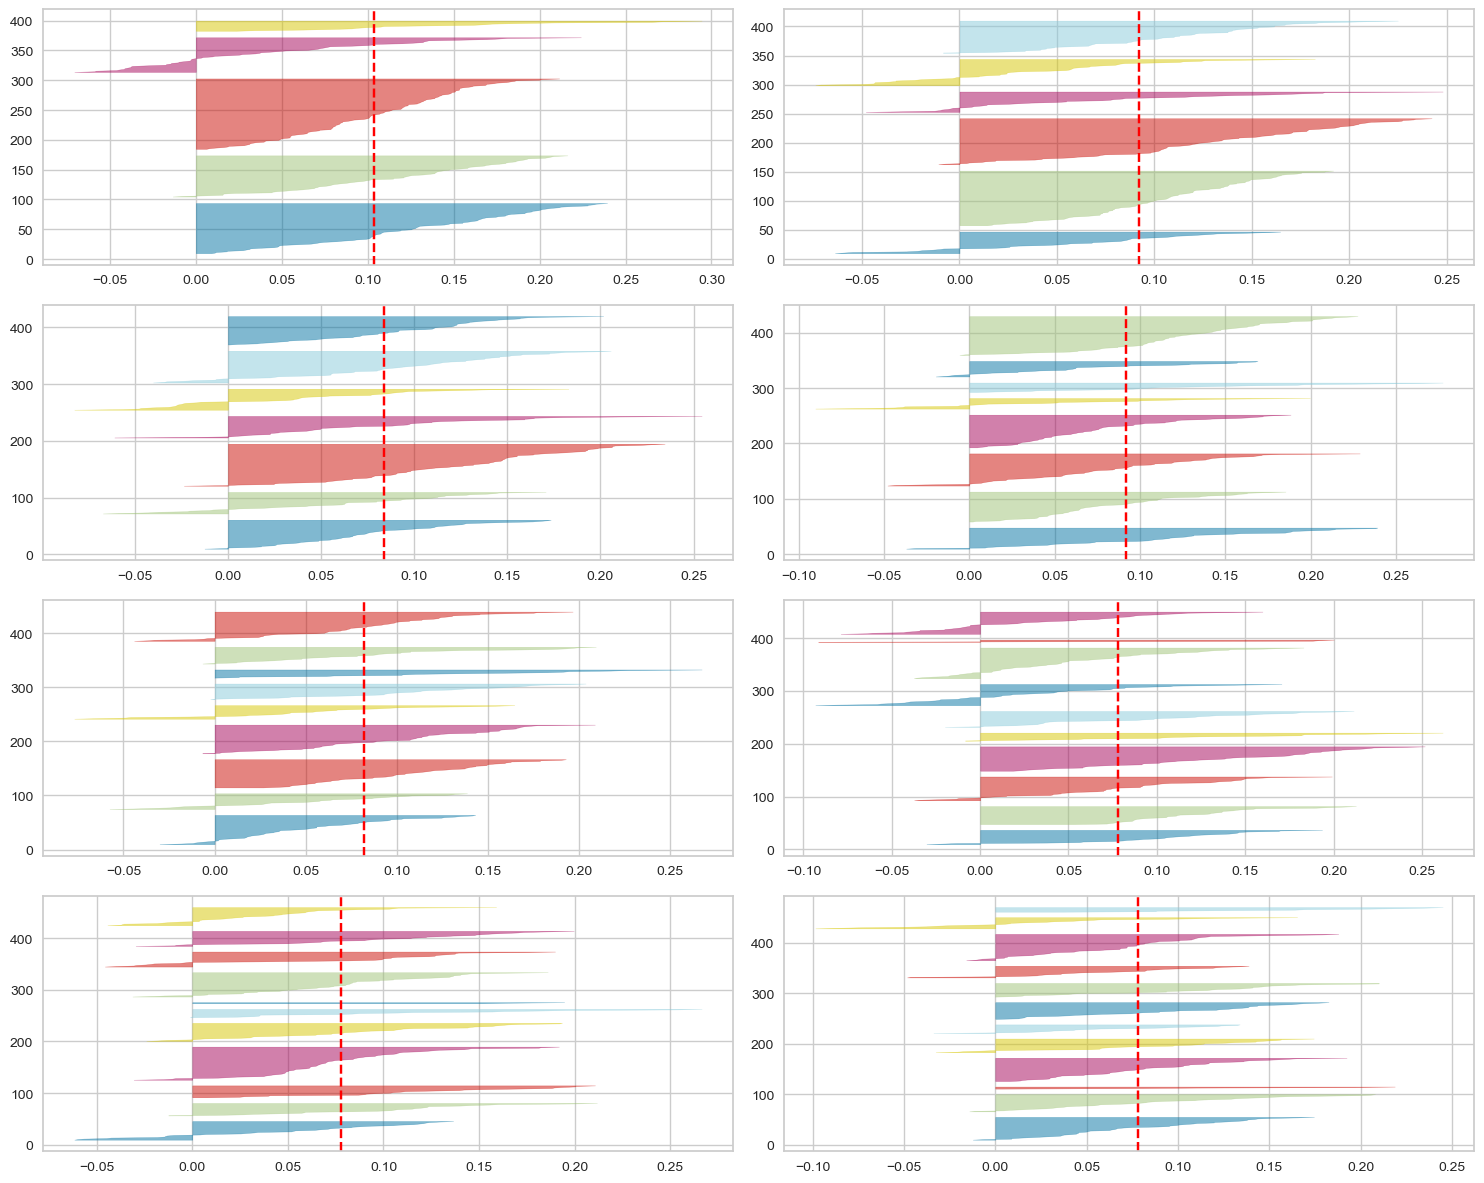

In [56]:
# Load the IRIS dataset
X = df_atrib_normalizadoMinMax

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(3,15))
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(4, 2, figsize=(15, 12))
for i, num_clusters in enumerate([5, 6, 7, 8, 9, 10, 11, 12]):
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=100)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(df_atrib_normalizadoMinMax)
    
    # Imprimir o score para o valor de k atual
    print(f"Score para k={num_clusters}: {km.score(df_atrib_normalizadoMinMax)}")

plt.tight_layout()
plt.show()